In [1]:
## for data
import numpy as np
import pandas as pd

In [2]:
import subprocess as sub

In [3]:
## for plotting
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline
import seaborn as sns

In [4]:
## for geospatial
import folium
import geopy

In [5]:
## for machine learning
from sklearn import preprocessing, cluster
import scipy

In [6]:
## for deep learning
import minisom

In [7]:
dtf = pd.read_csv('Book1.csv')

In [8]:
dtf.head()

district_id        name_en  postcode  latitude  longitude price_range
0            1   Akkaraipattu   32400.0  7.216700  81.850000        high
1            1  Ambagahawatta   90326.0  7.400000  81.300000         low
2            1         Ampara   32000.0  7.283300  81.666700      medium
3            1    Bakmitiyawa   32024.0  7.026268  81.633832        high
4            1    Deegawapiya   32006.0  7.283300  81.666700         low

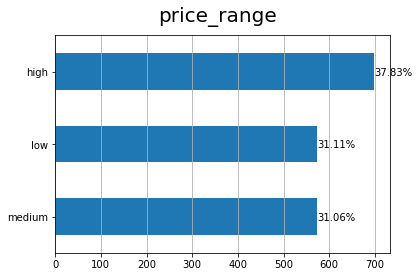

In [9]:
x = "price_range"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

In [10]:
name_en = 'Colombo'
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(name_en)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[latitude, longitude]:", location)

කොළඹ, Main Street, Gas Paha Junction, Fort, St. Bastian, Colombo, කොළඹ දිස්ත්‍රික්කය, බස්නාහිර පළාත, 01100, ශ්‍රී ලංකාව இலங்கை
[latitude, longitude]: [6.9387469, 79.8541134]


In [11]:
x, y = "latitude", "longitude"
color = "price_range"
size = "district_id"
popup = "name_en"
data = dtf.copy()

## create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(dtf[color].unique()))
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_


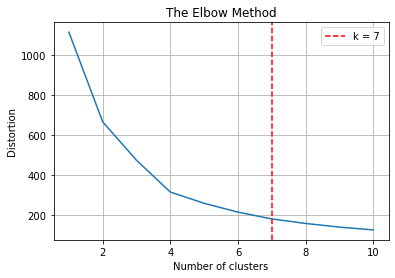

In [12]:
X = dtf[["latitude","longitude"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [13]:
k = 7
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = dtf[["latitude","longitude"]]
## clustering
dtf_X =X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, dtf_X.drop('cluster', axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(7)


C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


district_id         name_en  postcode  latitude  longitude price_range  \
1354           16        Udatenna   21006.0  7.416700  80.650000         low   
874            11   Sangarajapura   20044.0  7.316700  80.583300        high   
1133           14      Ibbagamuwa   60500.0  7.675000  80.366700         low   
1715           23       Kahangama   70016.0  6.704217  80.362927        high   
1617           22       Karathivu   61307.0  8.192511  79.832662         low   
1384           17  Kalubowitiyana   81478.0  6.316700  80.400000      medium   
735            10         Ratmale   81030.0  6.450000  80.200000      medium   

      cluster  centroids  
1354        5          0  
874         5          0  
1133        0          0  
1715        3          0  
1617        0          0  
1384        4          0  
735         4          0

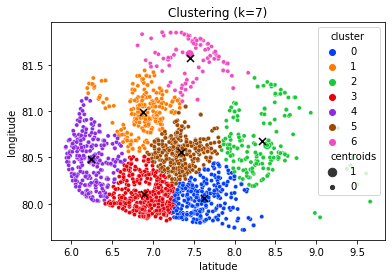

In [14]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="latitude", y="longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")


In [15]:
model = cluster.AffinityPropagation()

Text(0.5, 1.0, 'Clustering (k=7)')

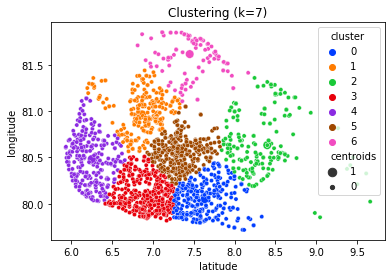

In [16]:
k = dtf["cluster"].nunique()
sns.scatterplot(x="latitude", y="longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief").set_title('Clustering (k='+str(k)+')')

In [17]:
X = dtf[["latitude","longitude"]]
map_shape = (4,4)
## scale data
scaler = preprocessing.StandardScaler()
X_preprocessed = scaler.fit_transform(X.values)
## clustering
model = minisom.MiniSom(x=map_shape[0], y=map_shape[1],input_len=X.shape[1])
model.train_batch(X_preprocessed, num_iteration=100, verbose=False)
## build output dataframe
dtf_X = X.copy()
dtf_X["cluster"] = np.ravel_multi_index(np.array([model.winner(x) for x in X_preprocessed]).T, dims=map_shape)



In [18]:
## find real centroids
model.cluster_centers_= np.array([vec for center in model.get_weights() 
                            for vec in center])
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, X_preprocessed)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


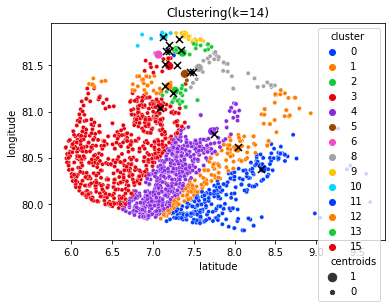

In [19]:
## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
## plot
k = dtf["cluster"].nunique()
fig, ax = plt.subplots()
sns.scatterplot(x="latitude", y="longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = scaler.inverse_transform(model.cluster_centers_)
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black',marker="x")


In [20]:
x, y = "latitude", "longitude"
color = "cluster"
size = "district_id"
popup = "name_en"
marker = "centroids"
data = dtf.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_